In [1]:
import utils.dataset_utils as dataset
import utils.train_utils as train

import os
import numpy as np
import copy
import pickle
import glob

from sklearn.base import BaseEstimator
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from scipy.fft import fft, ifft, fftfreq

from datetime import datetime
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (20.0, 10.0)
plt.rcParams['figure.dpi'] = 100
plt.rcParams['lines.linewidth'] = 0.75

from IPython.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

torch.cuda.is_available()

True

#### USE KALMAN FILTER TO SMOOTH RESULT? Not necessary

#### Is FFT or RFFT more stable with gradient descent? Equally stable RFFT is just faster
#### weight normalization?
#### seperate training of the last layer? Yes
#### Use different padding (first make the signal bigger than smaller)

#### Use CNN or GRU to smooth the output?
#### Does RAMAN also need smoothing?
#### mini (3 conv layers) seems to work as good as 5 conv layers, maybe a bit less. The edge diviate more than with the normal setup.
#### large ....

In [2]:
def unit_vector_norm(X):
    return (X.T / np.sqrt((X**2).sum(axis=1))).T

In [3]:
# DESKTOP
file_locations = ["../data/Raman_Mouse/preprocessed_2022-11-30 11-48-26.672496/",
                  "../data/Raman_Mouse/raman_2022-11-30 12-16-11.285597/",
                  "../data/Raman_Mouse/photoluminences_2022-11-30 12-16-25.050493/"]
# LAPTOP
# file_locations = ["../data/Raman_Mouse/preprocessed_2022-12-01 11-53-44.127304/",
#                   "../data/Raman_Mouse/raman_2022-12-01 12-13-34.452351/",
#                   "../data/Raman_Mouse/photoluminences_2022-12-01 12-13-35.526177/"]
# filenames = [sorted(glob.glob(file_location+'/[!Wave|!Liver|!Kidney]*.npy')) for file_location in file_locations]
# filenames = [sorted(glob.glob(file_location+'/[!Wave|!muscle]*.npy')) for file_location in file_locations]
filenames = [sorted(glob.glob(file_location+'/[!Wave]*.npy')) for file_location in file_locations]

saved_NN = "saved_NN_large"
os.makedirs(saved_NN, exist_ok=True)

basenames = [[os.path.splitext(os.path.basename(f))[0] for f in filename] for filename in filenames]

# check if all files exist
for name in basenames[0]:
    if not [b for b in basenames[1] if name in b]:
        raise ValueError(f"file {name} does not exist in the raman folder.")
    if not [b for b in basenames[2] if name in b]:
        raise ValueError(f"file {name} does not exist in the photo folder.")

if len(filenames[0]) != len(filenames[1]) or len(filenames[1]) != len(filenames[2]):
    raise ValueError("The folder do not have the same number of files.")
        

with open(f"{'/'.join(file_locations[0].split('/')[:-2])}/Sample_labels.pickle", 'rb') as f:
    labels = pickle.load(f)
labels = {l.split(".")[0]: val for l, val in labels.items()}
labels = list(zip(*sorted(labels.items())))[1]

wavenumbers = np.load(f"{file_locations[2]}Wavenumbers.npy")

NORM = False
func = unit_vector_norm if NORM else lambda x:x
    
data = []
for filename in filenames:
    tmp = []
    for f in filename: 
        x = np.load(f)
        tmp.append(func(x.reshape(-1,x.shape[-1])).reshape(x.shape))
    data.append(tmp)
data.append(labels)

data = list(zip(*data))

In [4]:
# saved_NN = "saved_NN_all"

In [5]:
nn.ReLU
nn.GELU
nn.LeakyReLU
nn.ELU

"""
Keep sum of weights positive,
imag part must be zero (loss function)
"""

class Conv_FFT(nn.Module):
    def __init__(self, num_input_channels : int = 2, base_channel_size: int = 16, act_fn : object = nn.GELU, groups : int = 2, **kwargs):
        super().__init__()
        c_hid = base_channel_size
        self.pretraining = True
        
        self.net = nn.Sequential(
            nn.Conv1d(num_input_channels, c_hid, kernel_size=11, padding=5, groups=groups, bias=False), 
            act_fn(),
            nn.Conv1d(c_hid, c_hid, kernel_size=9, padding=4, groups=groups, bias=False),
            act_fn(),
            nn.Conv1d(c_hid, c_hid, kernel_size=7, padding=4, groups=groups, bias=False),
            act_fn(),
            nn.Conv1d(c_hid, c_hid, kernel_size=7, padding=3, groups=2*groups, bias=False),
            act_fn(),
            nn.Conv1d(c_hid, c_hid, kernel_size=5, padding=2, groups=2*groups, bias=False),
            act_fn(),
            nn.Conv1d(c_hid, c_hid, kernel_size=3, padding=2, groups=2*groups, bias=False),
            act_fn(),
            nn.Conv1d(c_hid, 2*num_input_channels, kernel_size=3, padding=1, groups=2*groups, bias=False)
        )
        
        self.smooth = nn.Sequential(
            nn.Conv1d(1, c_hid, kernel_size=5, padding=2, groups=1, bias=False), 
            act_fn(),
            nn.Conv1d(c_hid, 1, kernel_size=3, padding=1, groups=1), 
        )
        
    def set_pretraining(self, value):
        self.pretraining = value
        
#     def forward(self, x):
#         n_wavenumbers = x.shape[-1]
#         d = 1
#         x = torch.fft.fft(x, dim=d, norm='backward')
#         x = torch.stack((x.real, x.imag), 1)
#         x = self.net(x)
#         x1, x2 = x[:,[0,2]], x[:,[1,3]]
#         x1, x2 = torch.transpose(x1, -2, -1).contiguous(), torch.transpose(x2, -2, -1).contiguous()
#         x1, x2 = torch.view_as_complex(x1), torch.view_as_complex(x2)
#         x1, x2 = torch.fft.ifft(x1, dim=d, norm='backward').real, torch.fft.ifft(x2, dim=d, norm='backward').real
#         if self.pretraining:
#             return x1, x2
#         return self.smooth(x1.reshape(-1, 1, n_wavenumbers)).reshape(x.shape[0],-1), x2
        
    def forward(self, x):
        n_wavenumbers = x.shape[-1]
        d = 1
        x = torch.fft.rfft(x, dim=d, norm='backward')
        x = torch.stack((x.real, x.imag), 1)
        x = self.net(x)
        x1, x2 = x[:,[0,2]], x[:,[1,3]]
        x1, x2 = torch.transpose(x1, -2, -1).contiguous(), torch.transpose(x2, -2, -1).contiguous()
        x1, x2 = torch.view_as_complex(x1), torch.view_as_complex(x2)
        x1, x2 = torch.fft.irfft(x1, n=n_wavenumbers, dim=d, norm='backward'), torch.fft.irfft(x2, n=n_wavenumbers, dim=d, norm='backward')
        if self.pretraining:
            return x1, x2
        return self.smooth(x1.reshape(-1, 1, n_wavenumbers)).reshape(x.shape[0],-1), x2
    
#     def forward(self, x):
#         """
#         Normal CNN
#         """
#         x = x.reshape(-1, 1, x.shape[-1])
#         x = self.net(x).reshape(x.shape[0],-1)
#         return x

In [6]:
class SupervisedClassifier(BaseEstimator):
    def __init__(self, **kwargs):
        self.kwargs = kwargs

        _use_cuda = torch.cuda.is_available() and kwargs['cuda']
        if _use_cuda:
            torch.backends.cudnn.enabled = True
            torch.backends.cudnn.benchmark = True
        self.device = torch.device('cuda' if _use_cuda else 'cpu')        
        print(f"device: {self.device}")
        
    def fit(self, data):
        self.model = Conv_FFT().to(self.device)

        parameters = filter(lambda x: x.requires_grad, self.model.parameters())
        self.optimizer = optim.Adam(parameters, lr=self.kwargs['lr'])                
        self.train_loader, self.test_loader = dataset.load_splitdata(data, self.kwargs['batch_size'])
            
        for epoch in range(self.kwargs['epochs']):
            if os.path.exists(f"{saved_NN}//Conv_FFT_model_epoch{epoch}.pt"):
                print(f"epoch {epoch} is already trained")
                if not os.path.exists(f"{saved_NN}//Conv_FFT_model_epoch{epoch+1}.pt"):
                    self.model = torch.load(f"{saved_NN}//Conv_FFT_model_epoch{epoch}.pt") 
                    parameters = filter(lambda x: x.requires_grad, self.model.parameters())
                    self.optimizer = optim.Adam(parameters, lr=self.kwargs['lr'])  
                    self.model.set_pretraining(False)
                continue 
                
            if epoch == 3:
                self.model.set_pretraining(False)

            print('-'*50)
            print('Epoch {:3d}/{:3d}'.format(epoch, self.kwargs['epochs']))
            start_time = datetime.now()
            train.train(self.model, self.optimizer, self.train_loader, self.kwargs['loss_func'], self.kwargs['acc_func'], self.kwargs['log_step'], self.device)
            end_time = datetime.now()
            time_diff = relativedelta(end_time, start_time)
            print('Elapsed time: {}h {}m {}s'.format(time_diff.hours, time_diff.minutes, time_diff.seconds))
            train.test(self.model, self.test_loader, self.kwargs['loss_func'], self.kwargs['acc_func'], self.kwargs['log_step'], self.device)
            torch.save(self.model, f"{saved_NN}//Conv_FFT_model_epoch{epoch}.pt")
        return self
    
    def predict(self, data=None):
        """
        """
        if data is not None:
            dataloader, _ = dataset.load_splitdata(data, self.kwargs['batch_size'], test_size=None)
            for batch_idx, (x, *y) in enumerate(dataloader):
                x = x.to(self.device)
                y_1, y_2 = self.model(x)
                y1, y2, *_ = y
                yield x.cpu().detach().numpy(), y1, y2, y_1.cpu().detach().numpy(), y_2.cpu().detach().numpy()
        else:
            for batch_idx, (x, *y) in enumerate(self.test_loader):
                x = x.to(self.device)
                y_1, y_2 = self.model(x)
                y1, y2, *_ = y
                yield x.cpu().detach().numpy(), y1, y2, y_1.cpu().detach().numpy(), y_2.cpu().detach().numpy()

In [19]:
loss1 = nn.MSELoss(size_average=None, reduce=None, reduction='mean')
loss2 = nn.L1Loss(size_average=None, reduce=None, reduction='mean')
# loss3 = nn.KLDivLoss(size_average=None, reduce=None, reduction='batchmean', log_target=False)
# both closely related
# loss4 = nn.HuberLoss(reduction='mean', delta=100.0)
# loss5 = nn.SmoothL1Loss(size_average=None, reduce=None, reduction='mean', beta=1.0)

def loss_func(y, y_, x):
    raman, photo, _ = y
    raman = raman.to(y_[0].device)
    photo = photo.to(y_[0].device)
    return loss1(y_[0], photo) + loss1(y_[1], raman) #+ torch.mean(torch.sum(F.relu(y_[0] + y_[1] - x), 1)) # + loss1(y_[0] + y_[1], x)

def acc_func(y, y_, x, data="train"):
    y_1, y_2 = y_
    y_1, y_2 = y_1.cpu().detach().numpy(), y_2.cpu().detach().numpy()
    x = x.cpu().detach().numpy()
    plt.title(f"plot {data} data")
    plt.plot(x[0], label='raw')
    plt.plot(y_1[0] + y_2[0], label='raman+photo')
    plt.plot(np.abs(x[0]-y_1[0]-y_2[0]), label='noise', color='orange')
    plt.plot(y[0][0], label='raman', color='c')
    plt.plot(y[1][0], label='photo', color='r')
    plt.plot(y_1[0], label='Conv1', color='g')
    plt.plot(y_2[0], label='Conv2', color='brown')
    plt.ylim(ymin=-10)
    plt.xlim(xmin=0, xmax=1300)
    plt.legend()
    plt.show()
    return loss_func(y, y_, x)

In [20]:
BATCH_SIZE = 64
EPOCHS = 51

kwargs = {'batch_size': BATCH_SIZE,
          'cuda': True,
          'log_step': 5000,
          'epochs': EPOCHS,
          'loss_func': loss_func,
          'acc_func' : acc_func,
          'bias': True,
          'lr': 0.001
         }

device: cuda
epoch 0 is already trained
epoch 1 is already trained
epoch 2 is already trained
epoch 3 is already trained
epoch 4 is already trained
epoch 5 is already trained
epoch 6 is already trained
epoch 7 is already trained
epoch 8 is already trained
epoch 9 is already trained
epoch 10 is already trained
epoch 11 is already trained
epoch 12 is already trained
epoch 13 is already trained
epoch 14 is already trained
epoch 15 is already trained
epoch 16 is already trained
epoch 17 is already trained
epoch 18 is already trained
epoch 19 is already trained
epoch 20 is already trained
epoch 21 is already trained
epoch 22 is already trained
epoch 23 is already trained
epoch 24 is already trained
epoch 25 is already trained
epoch 26 is already trained
epoch 27 is already trained
epoch 28 is already trained
epoch 29 is already trained
epoch 30 is already trained
epoch 31 is already trained
epoch 32 is already trained
epoch 33 is already trained
epoch 34 is already trained
-----------------

  2022-12-08 14:56:52|     0/ 2696| bits: 0.000347
Elapsed time: 0h 0m 32s


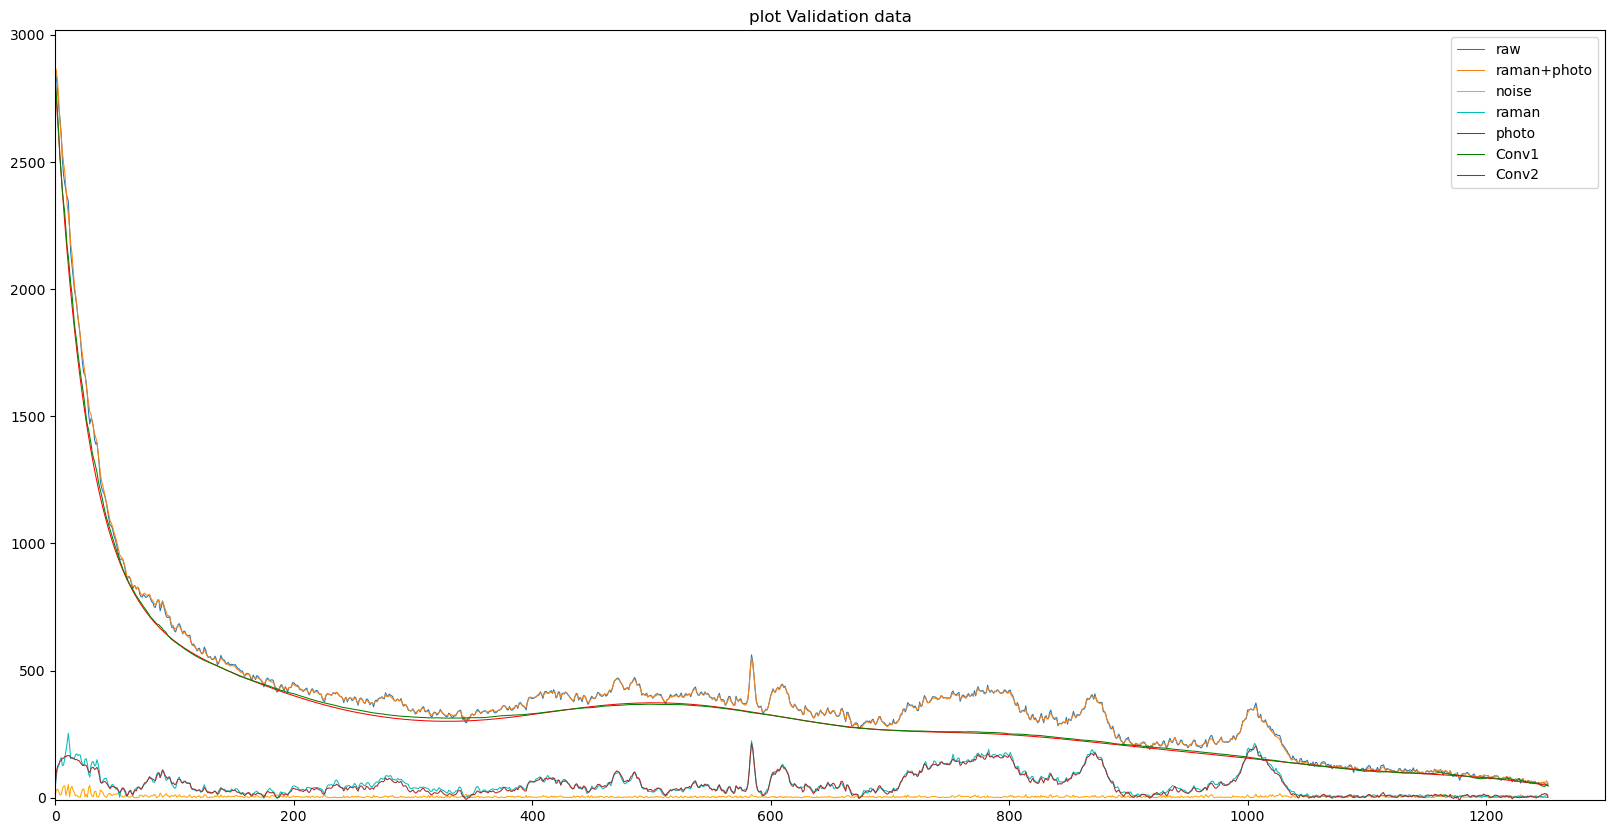

  2022-12-08 14:57:25|     0/  293| bits: 0.000291
Validation average loss: 0.00030704878736287355
--------------------------------------------------
Epoch  36/ 51


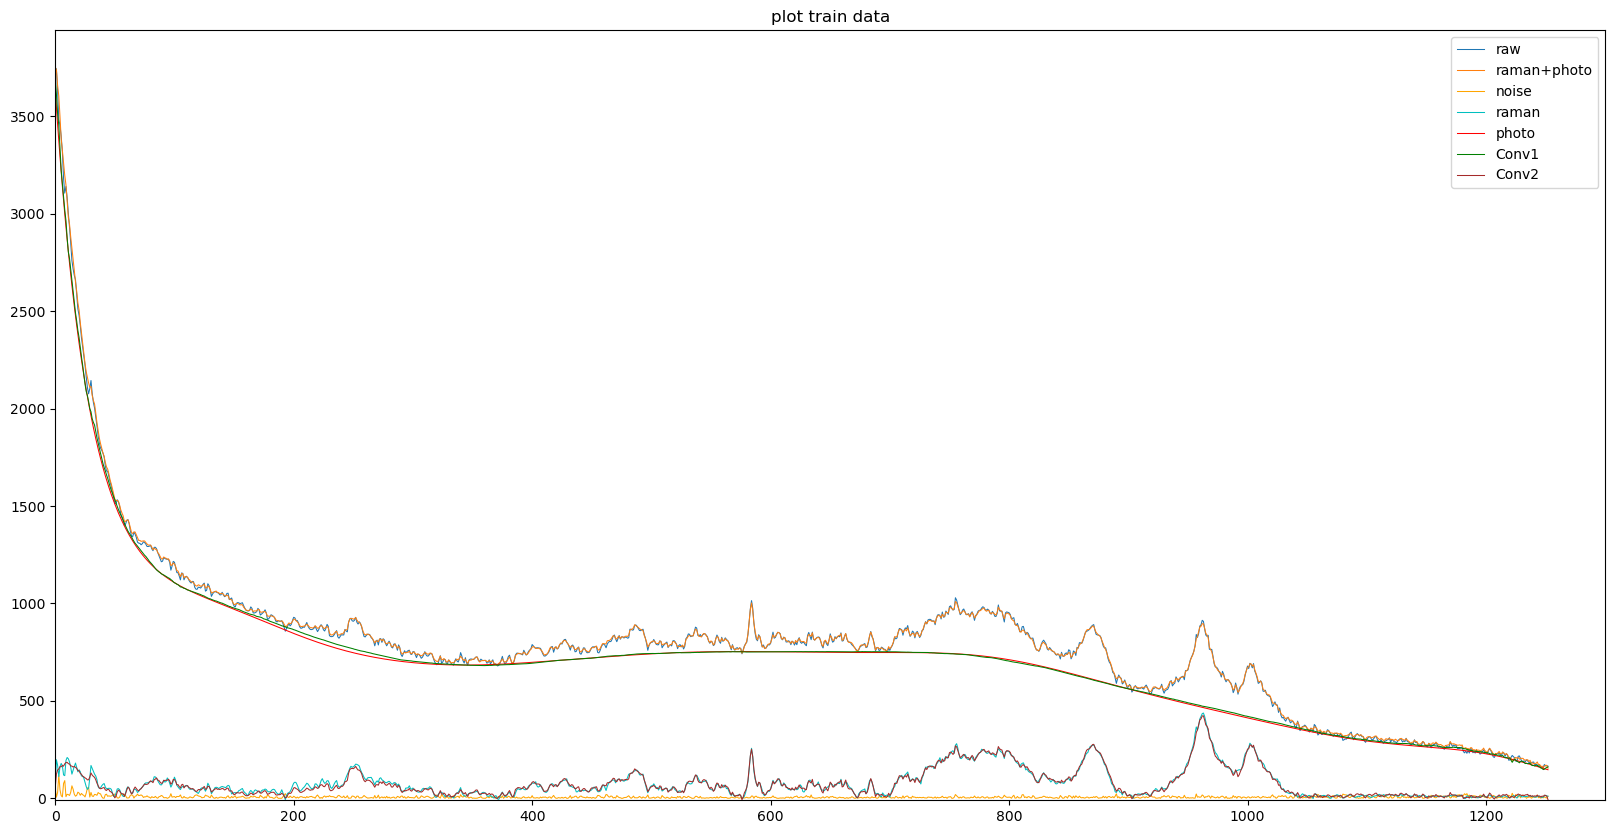

  2022-12-08 14:57:27|     0/ 2696| bits: 0.000276
Elapsed time: 0h 0m 33s


  2022-12-08 14:58:01|     0/  293| bits: 0.000283
Validation average loss: 0.0003325793659314513
--------------------------------------------------
Epoch  37/ 51


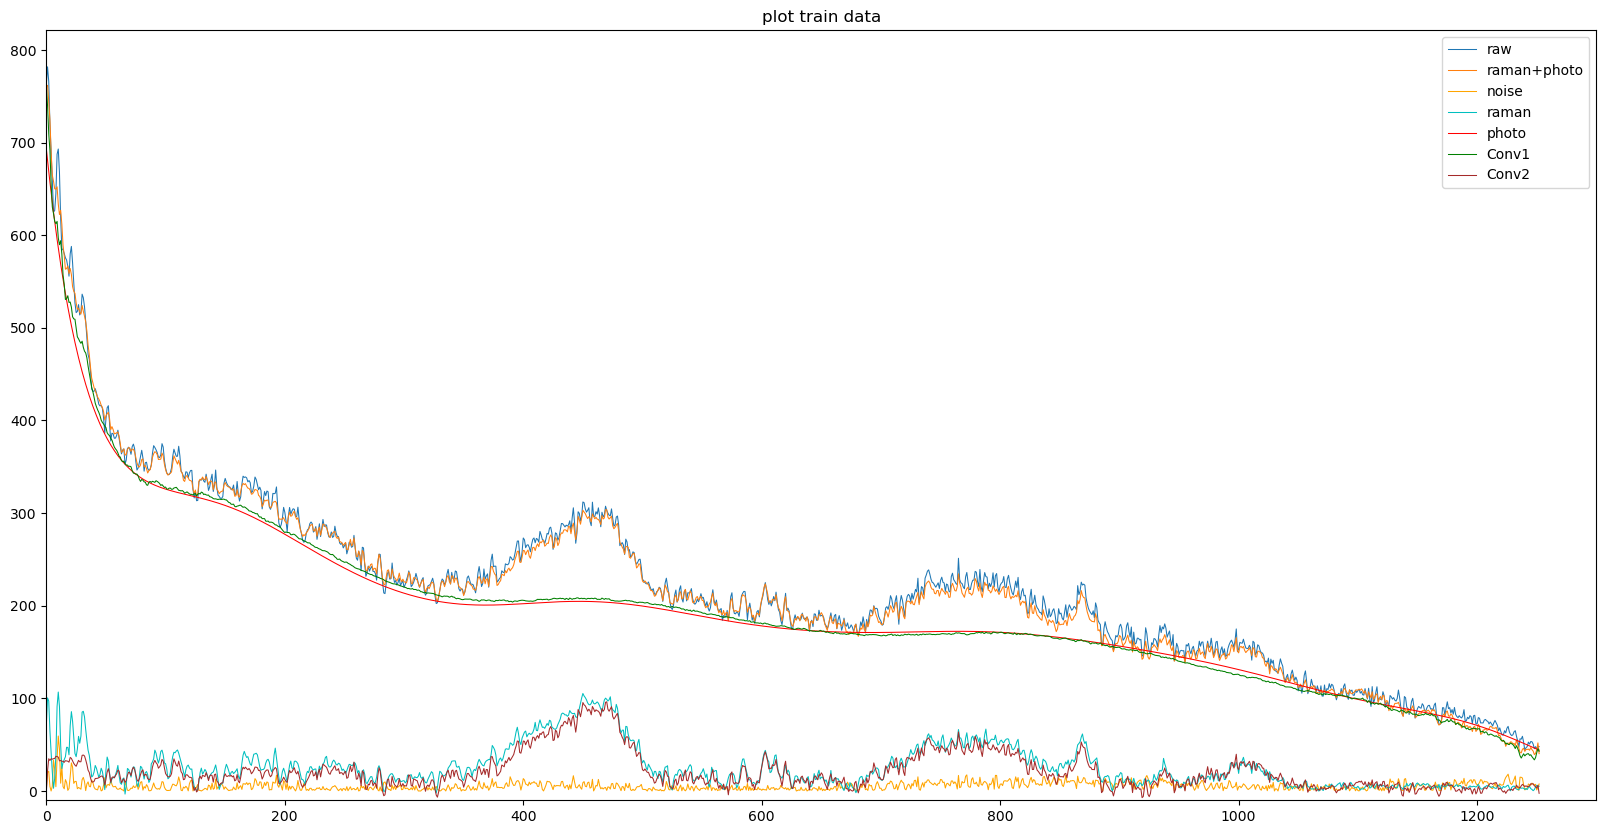

  2022-12-08 14:58:03|     0/ 2696| bits: 0.000324
Elapsed time: 0h 0m 34s


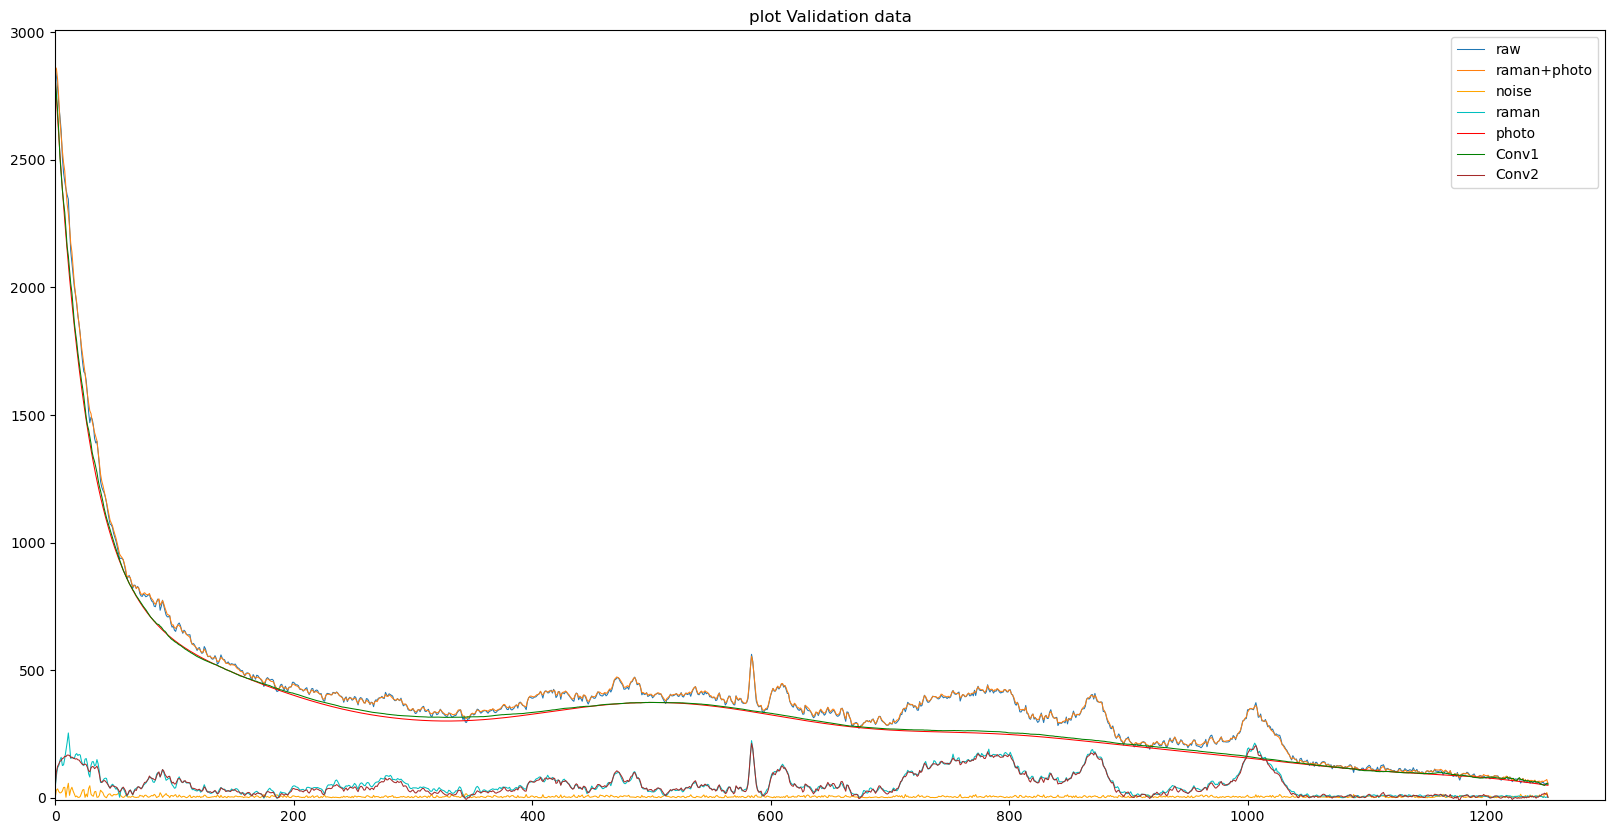

  2022-12-08 14:58:38|     0/  293| bits: 0.000279
Validation average loss: 0.0003253903705626726
--------------------------------------------------
Epoch  38/ 51


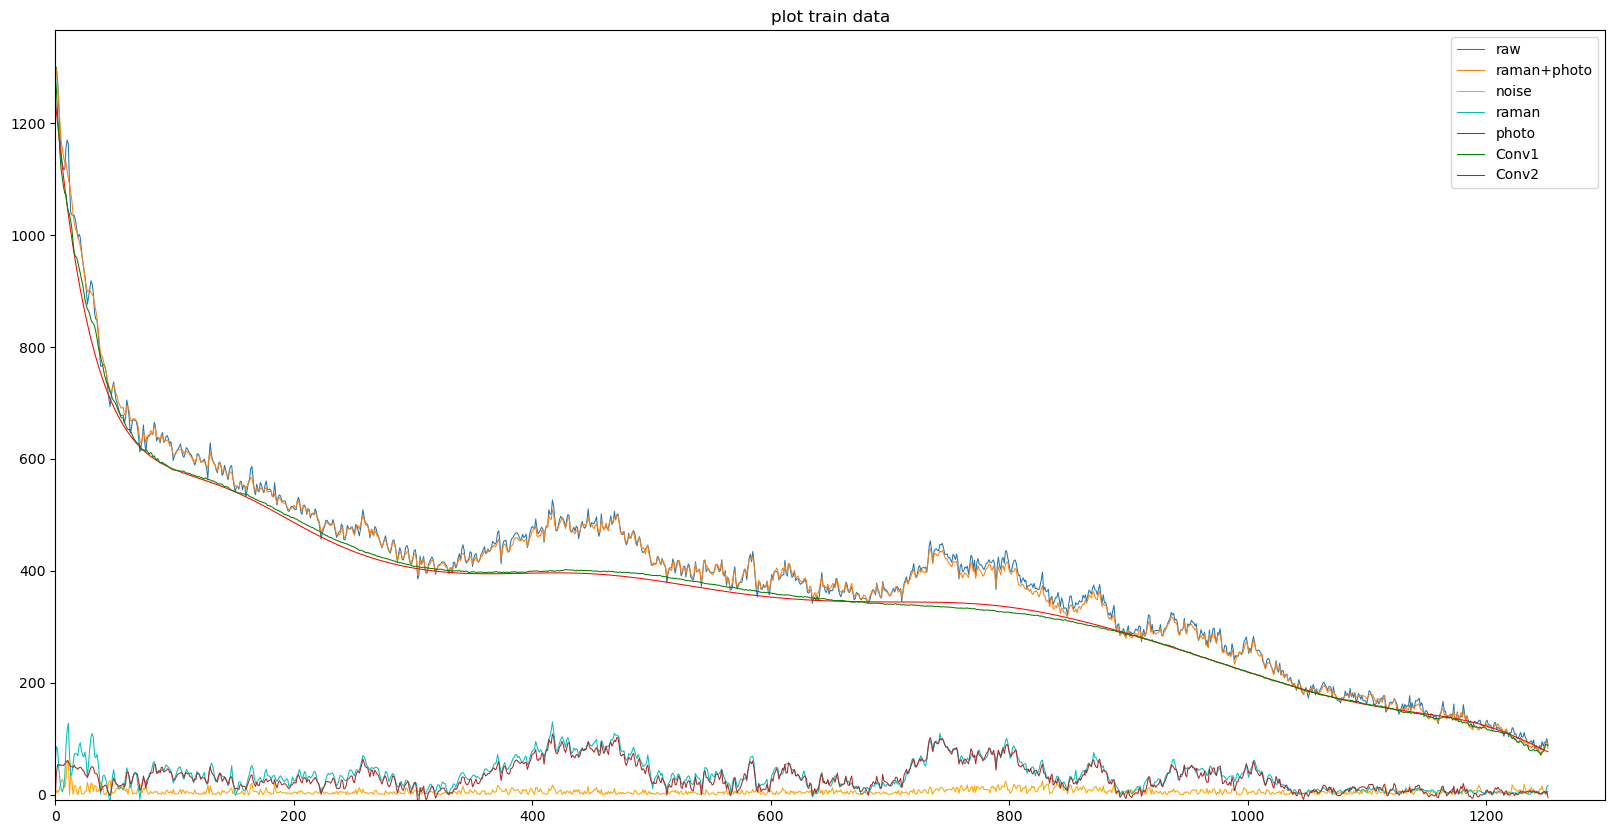

  2022-12-08 14:58:40|     0/ 2696| bits: 0.000299
Elapsed time: 0h 0m 34s


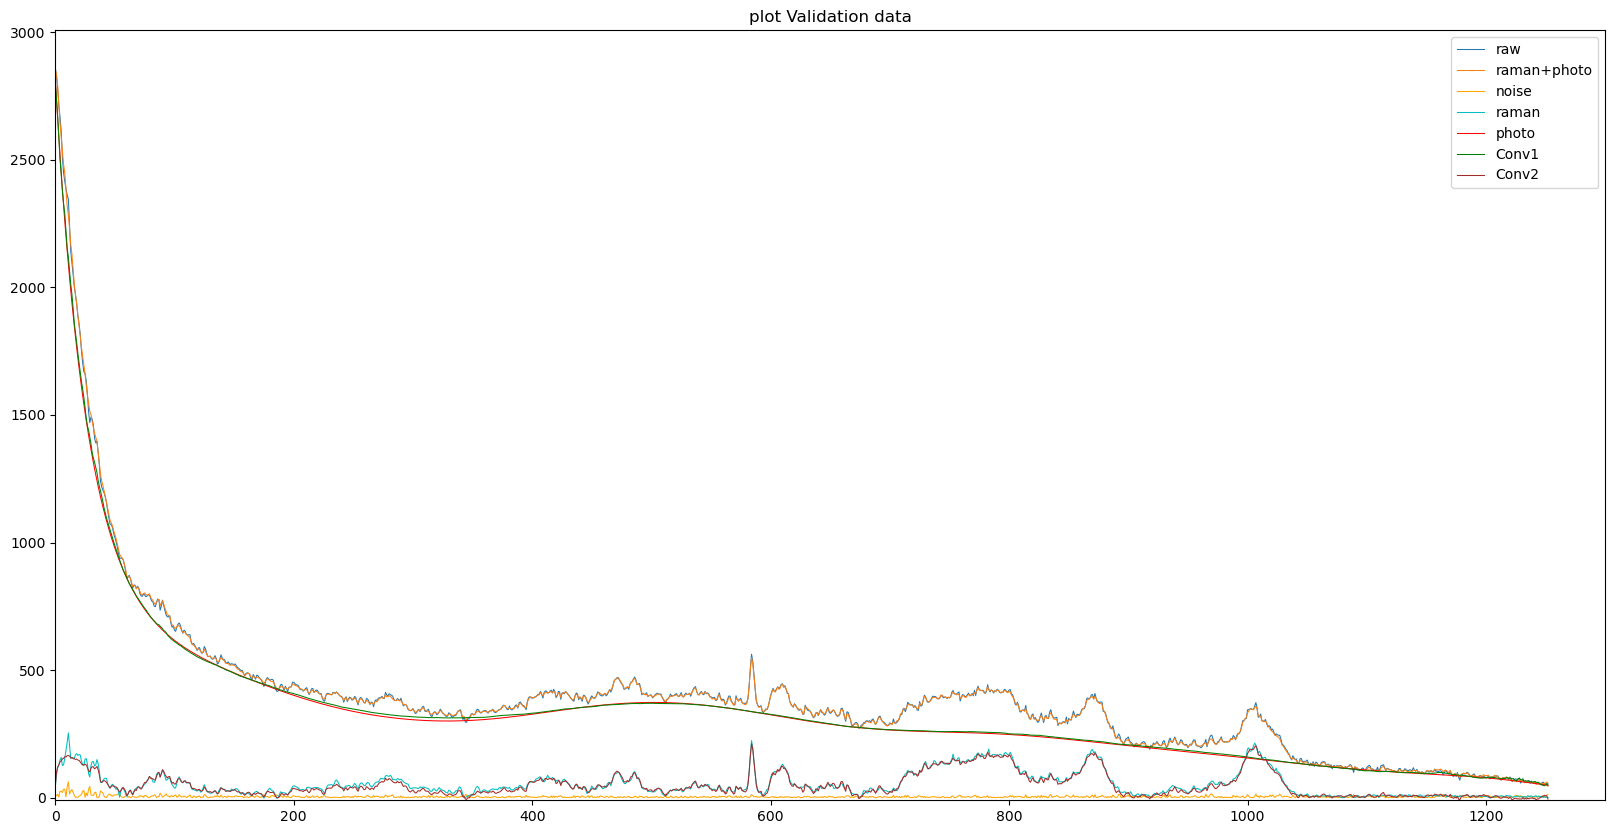

  2022-12-08 14:59:14|     0/  293| bits: 0.000266
Validation average loss: 0.0002921582490671426
--------------------------------------------------
Epoch  39/ 51


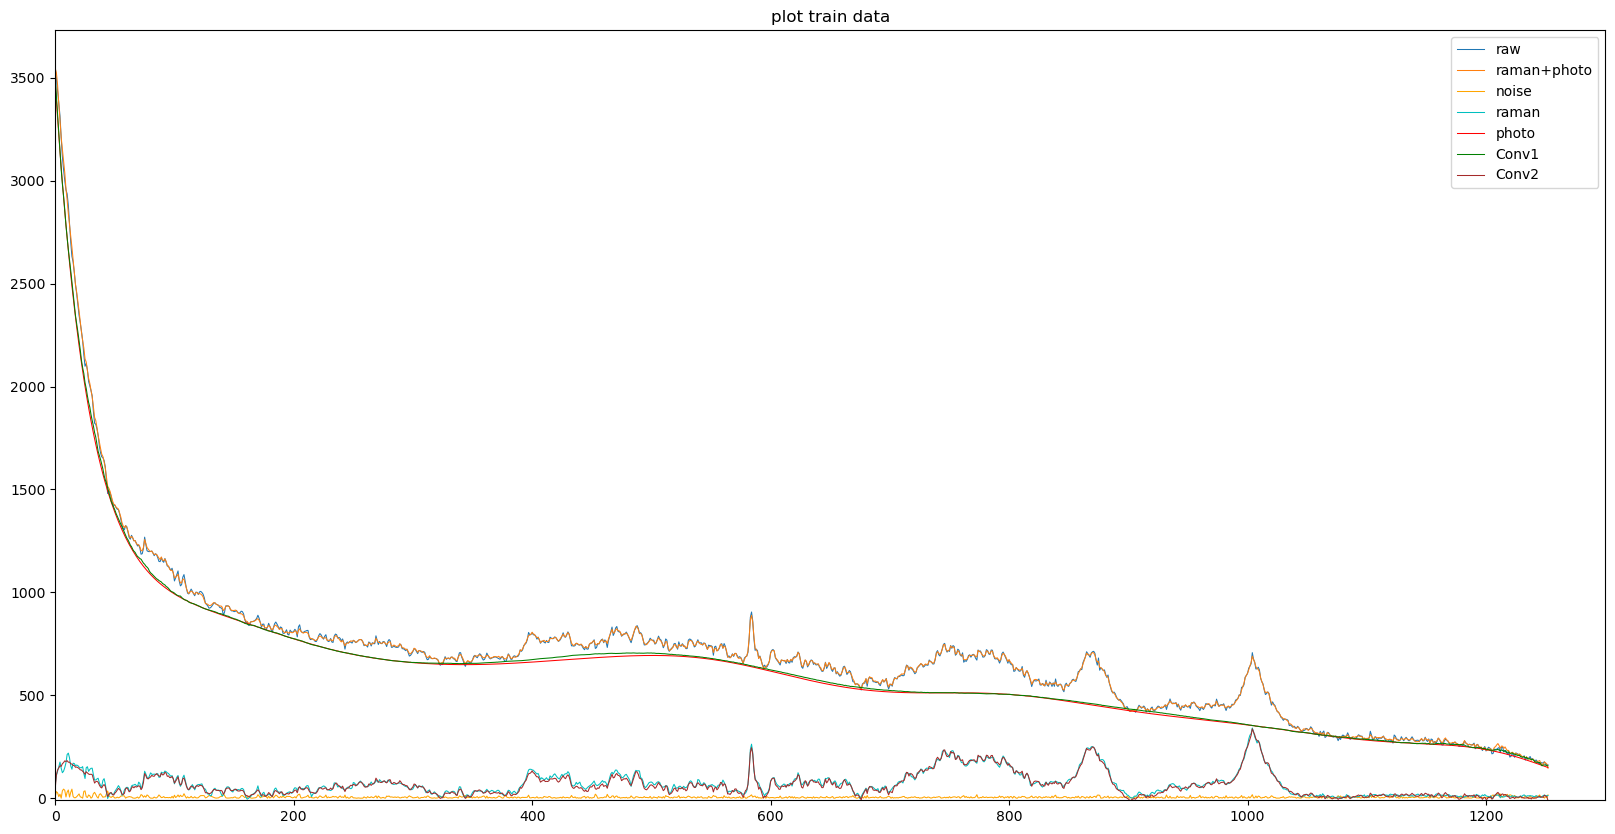

  2022-12-08 14:59:17|     0/ 2696| bits: 0.000259
Elapsed time: 0h 0m 33s


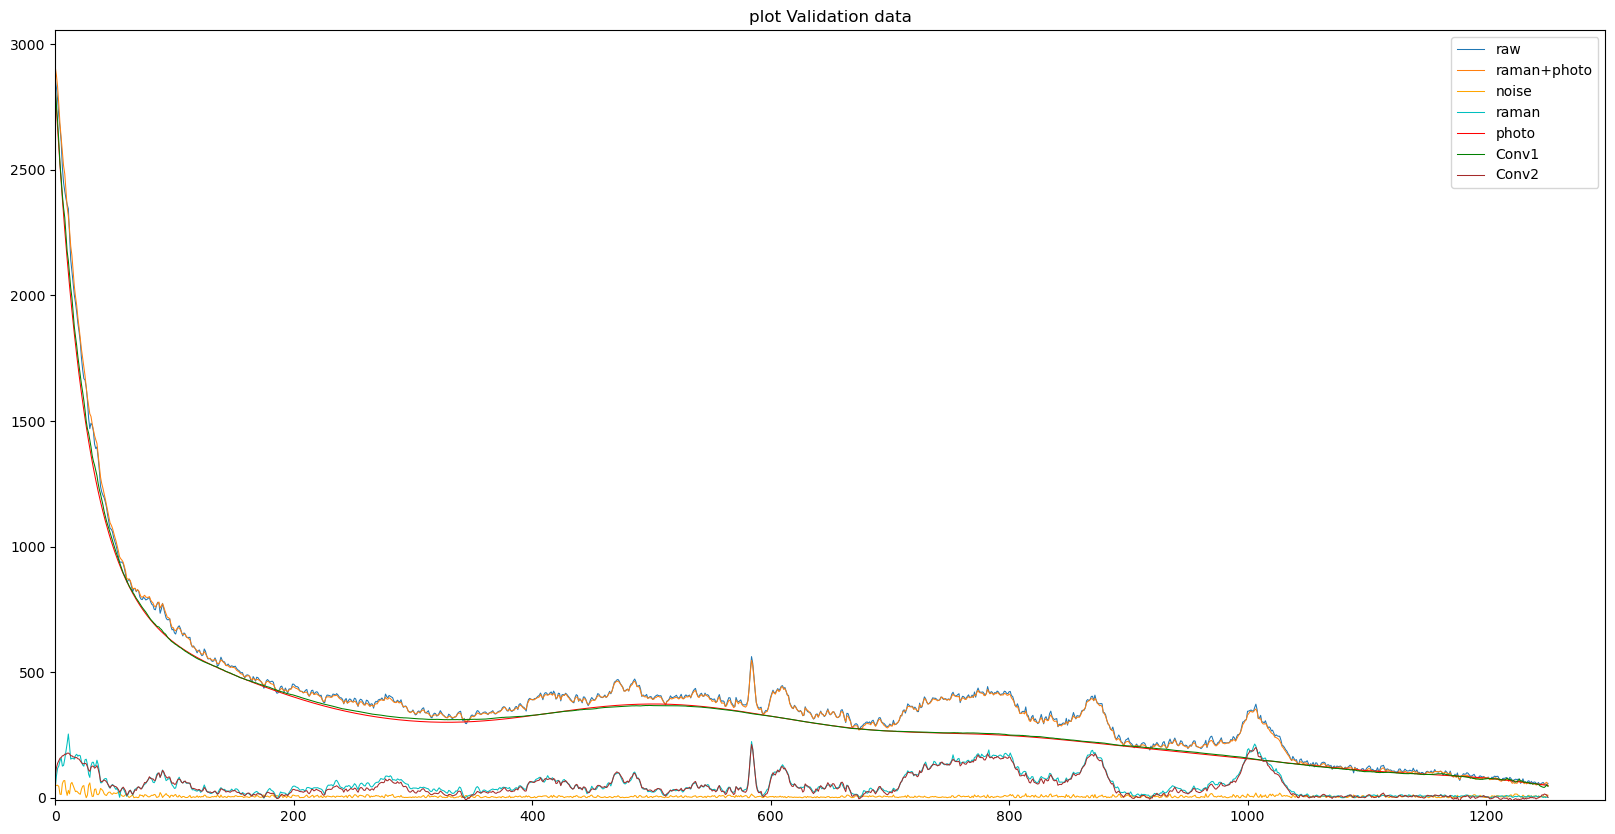

  2022-12-08 14:59:50|     0/  293| bits: 0.000329
Validation average loss: 0.00035753229167312384
--------------------------------------------------
Epoch  40/ 51


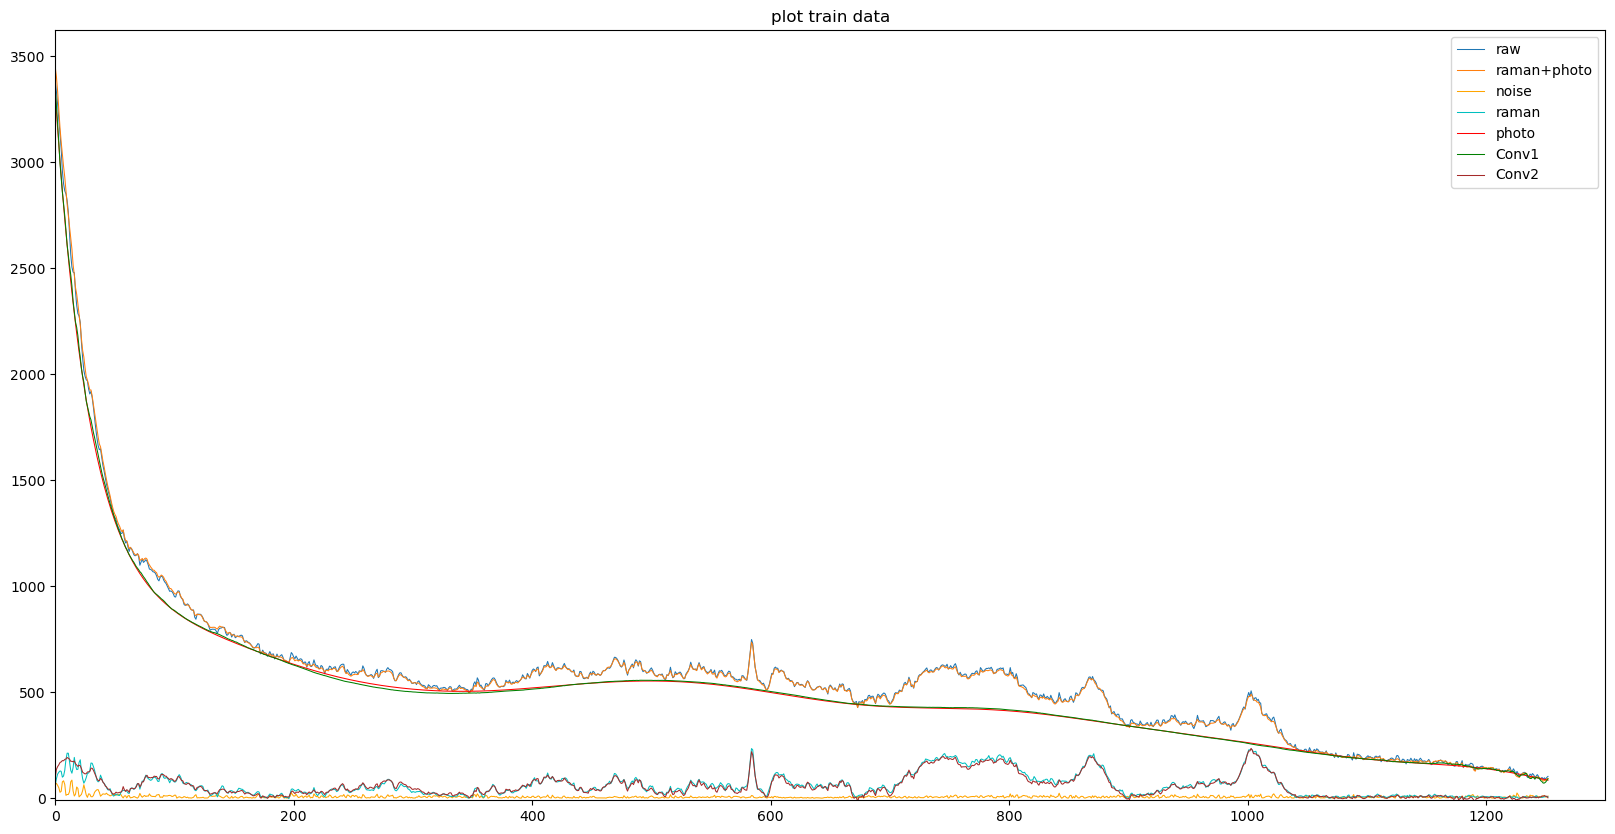

  2022-12-08 14:59:52|     0/ 2696| bits: 0.000376
Elapsed time: 0h 0m 33s


  2022-12-08 15:00:26|     0/  293| bits: 0.000297
Validation average loss: 0.00028835146804340184
--------------------------------------------------
Epoch  41/ 51


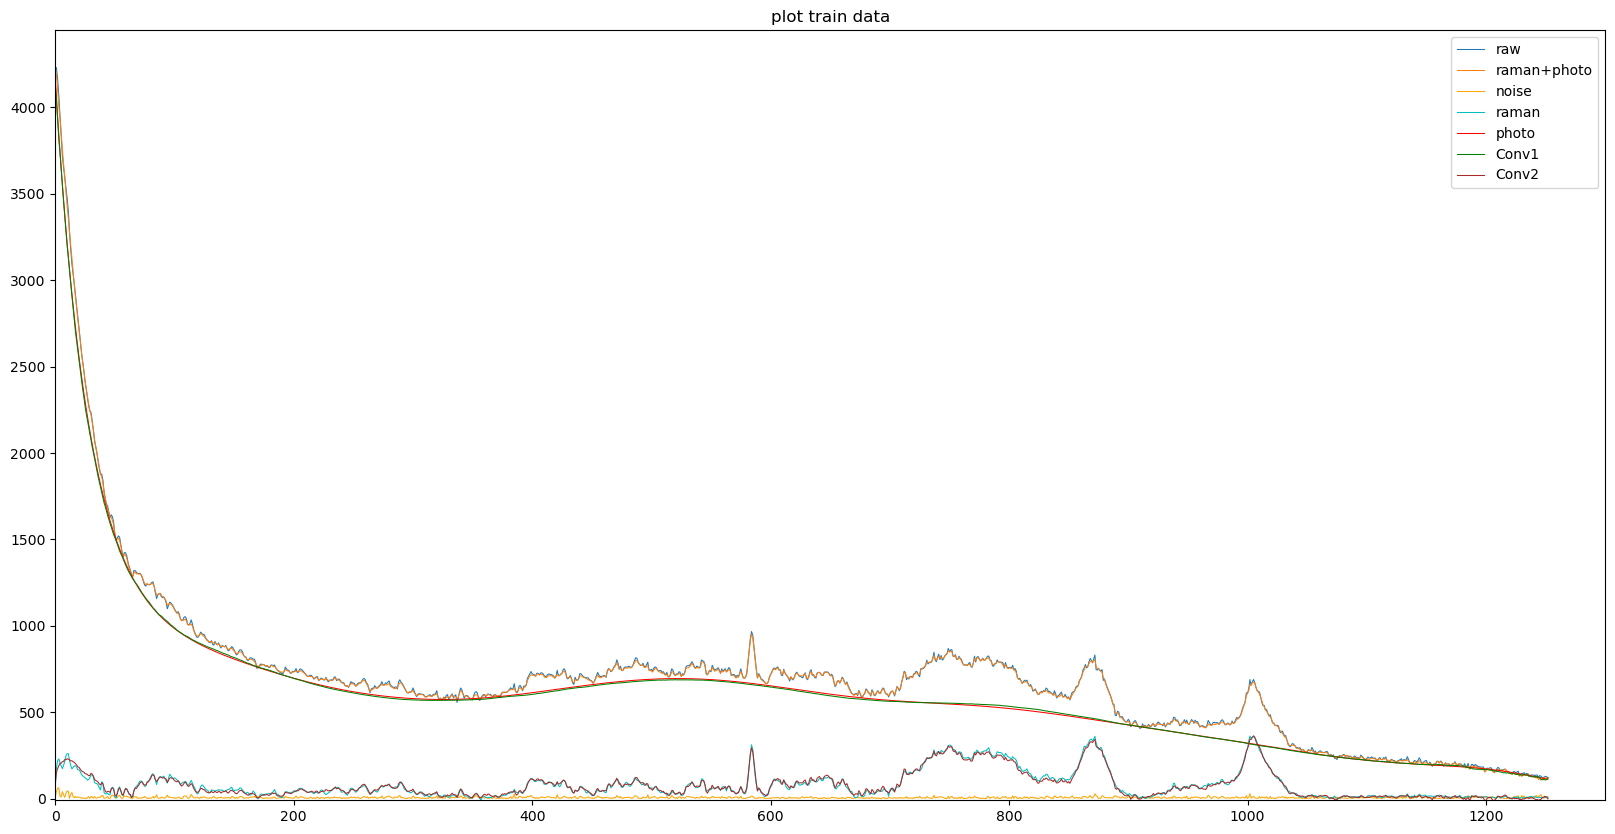

  2022-12-08 15:00:28|     0/ 2696| bits: 0.000278
Elapsed time: 0h 0m 33s


  2022-12-08 15:01:02|     0/  293| bits: 0.000308
Validation average loss: 0.0003168486582580954
--------------------------------------------------
Epoch  42/ 51


  2022-12-08 15:01:04|     0/ 2696| bits: 0.003952
Elapsed time: 0h 0m 33s


  2022-12-08 15:01:38|     0/  293| bits: 0.000301
Validation average loss: 0.0003186013491358608
--------------------------------------------------
Epoch  43/ 51


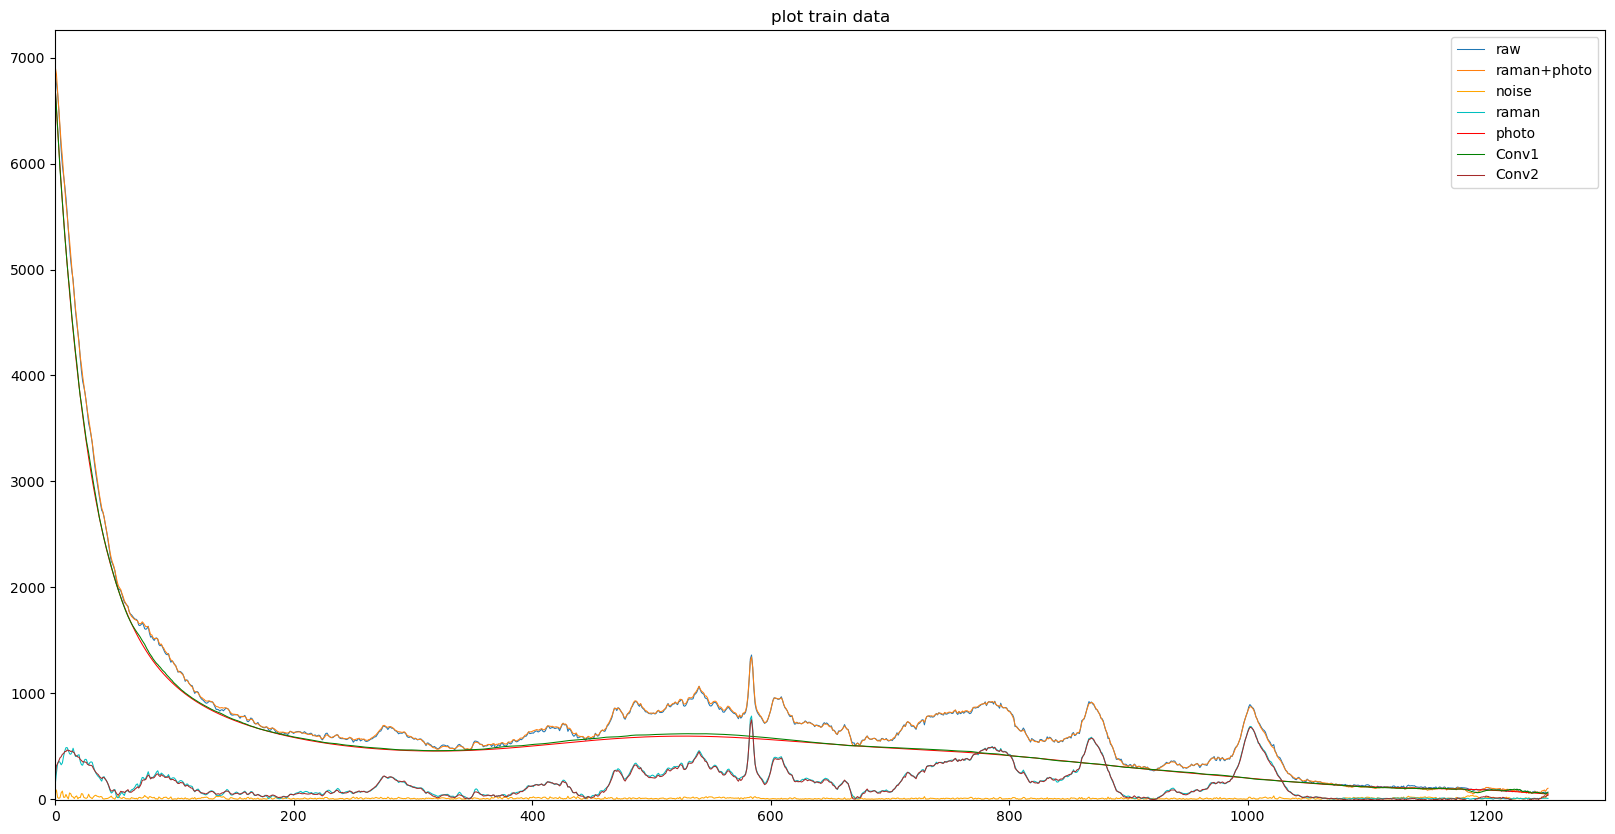

  2022-12-08 15:01:40|     0/ 2696| bits: 0.000338
Elapsed time: 0h 0m 35s


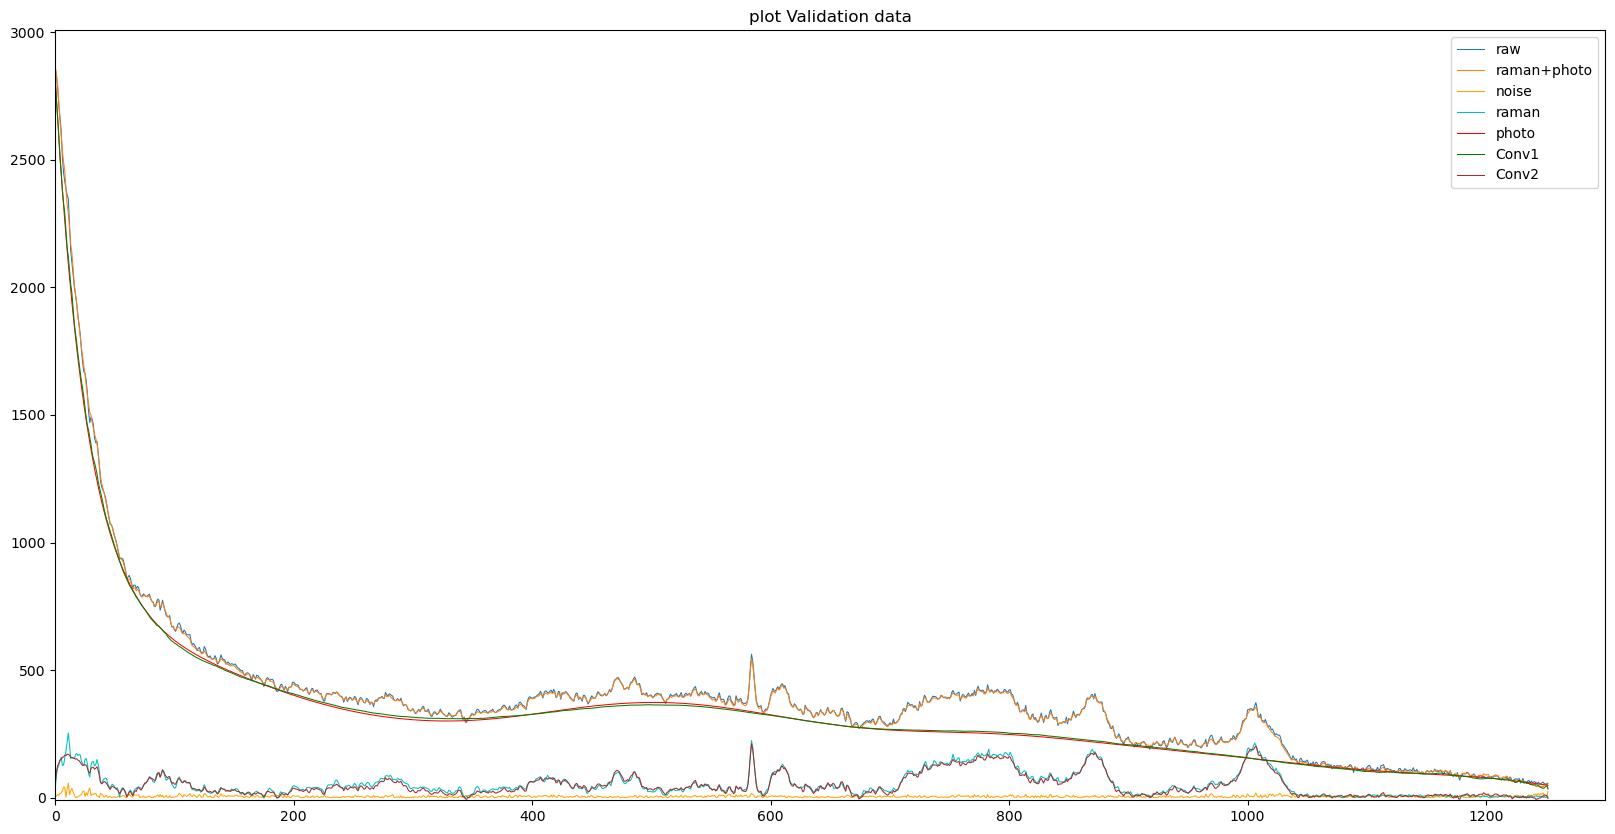

  2022-12-08 15:02:16|     0/  293| bits: 0.000307
Validation average loss: 0.00030943131423555315
--------------------------------------------------
Epoch  44/ 51


  2022-12-08 15:02:19|     0/ 2696| bits: 0.000273
Elapsed time: 0h 0m 34s


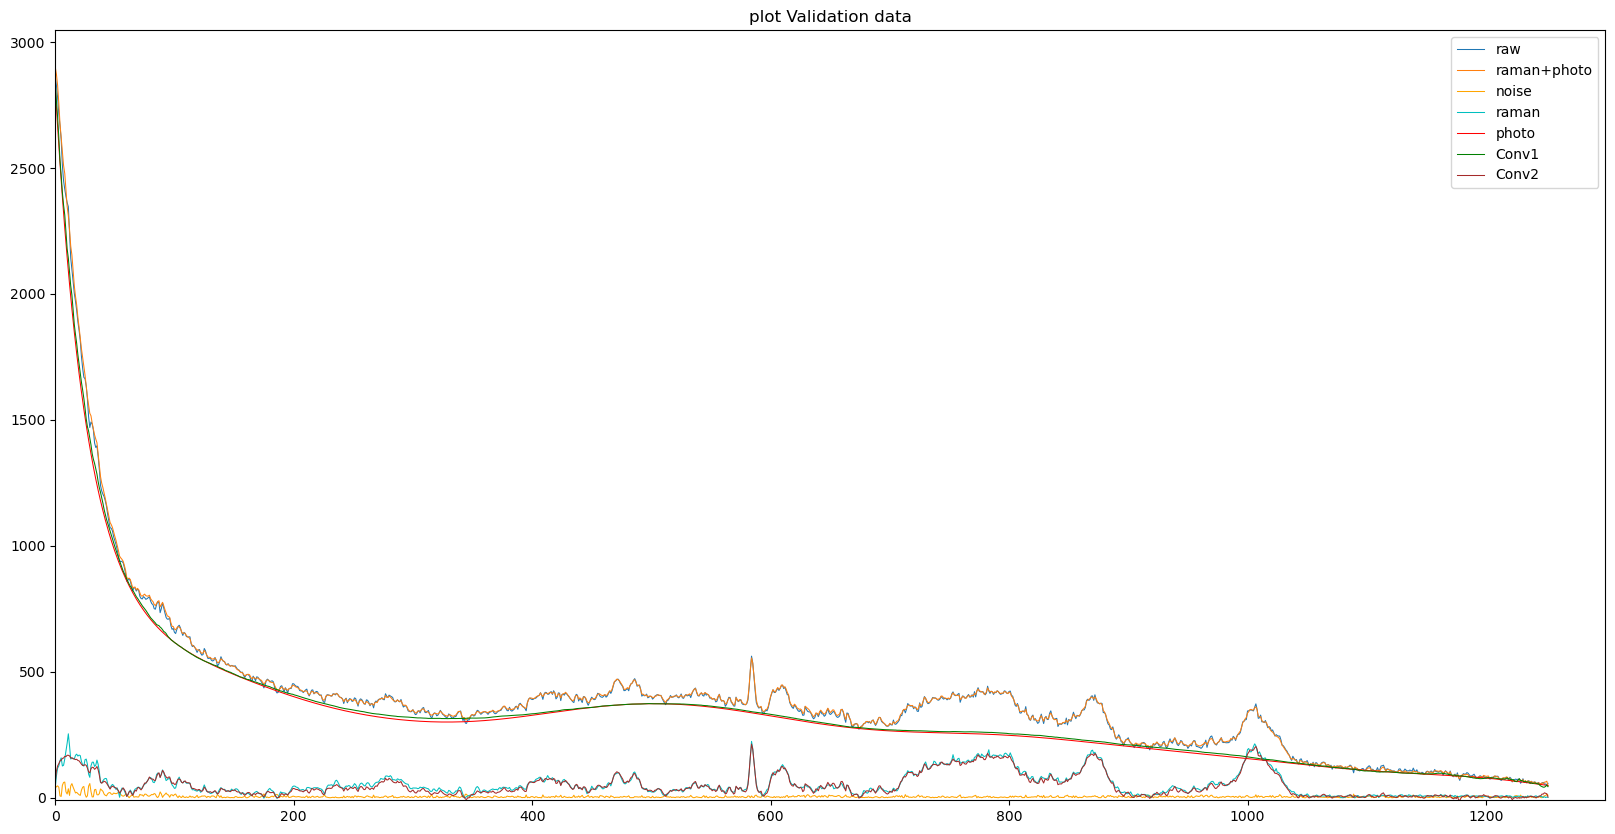

  2022-12-08 15:02:53|     0/  293| bits: 0.000328
Validation average loss: 0.0004232785140629858
--------------------------------------------------
Epoch  45/ 51


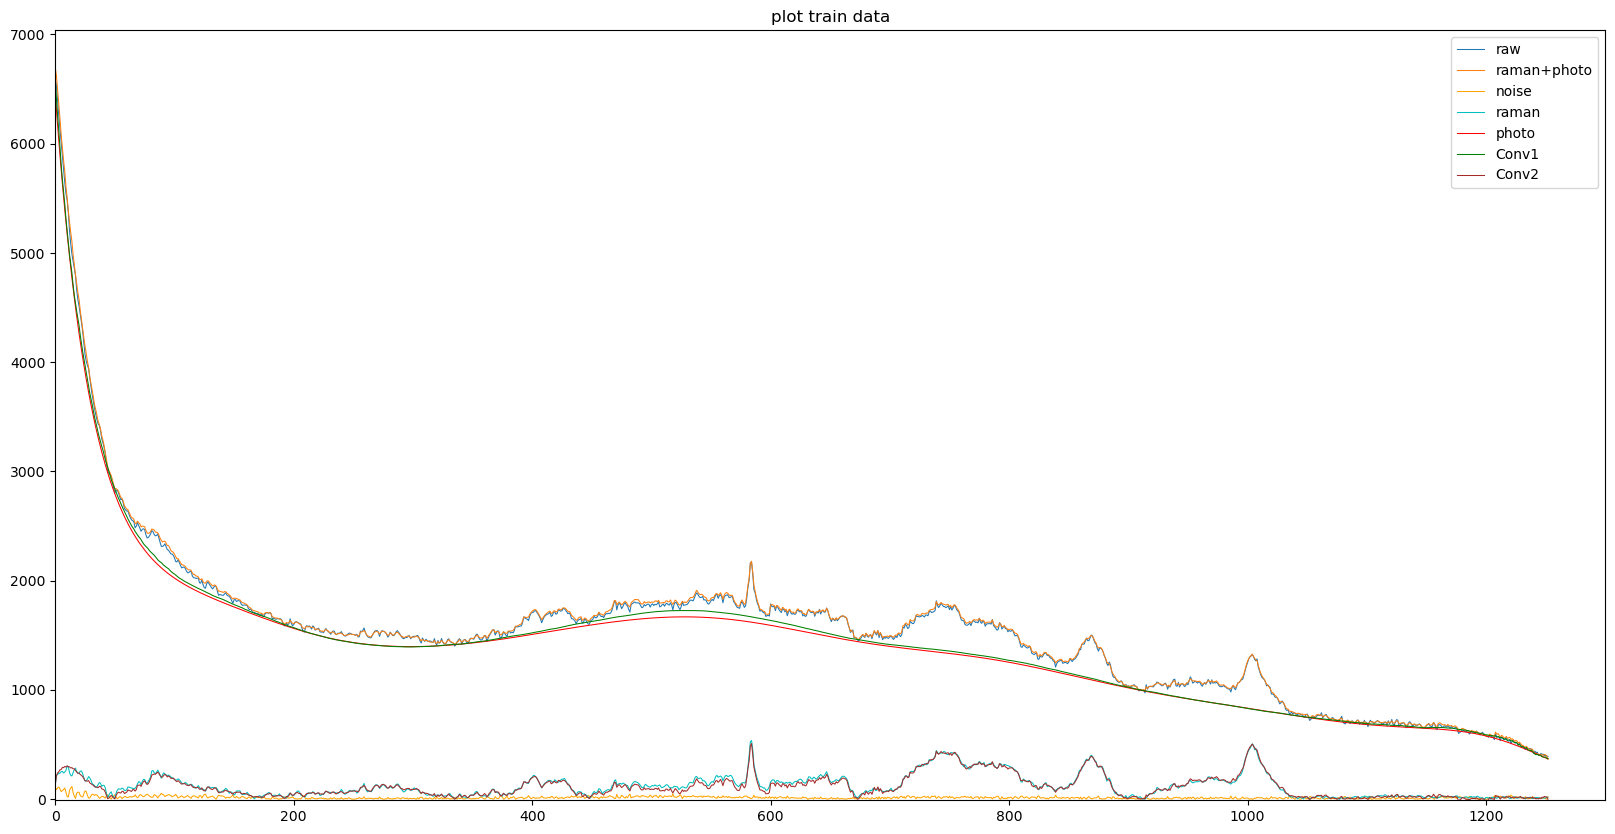

  2022-12-08 15:02:55|     0/ 2696| bits: 0.000412
Elapsed time: 0h 0m 34s


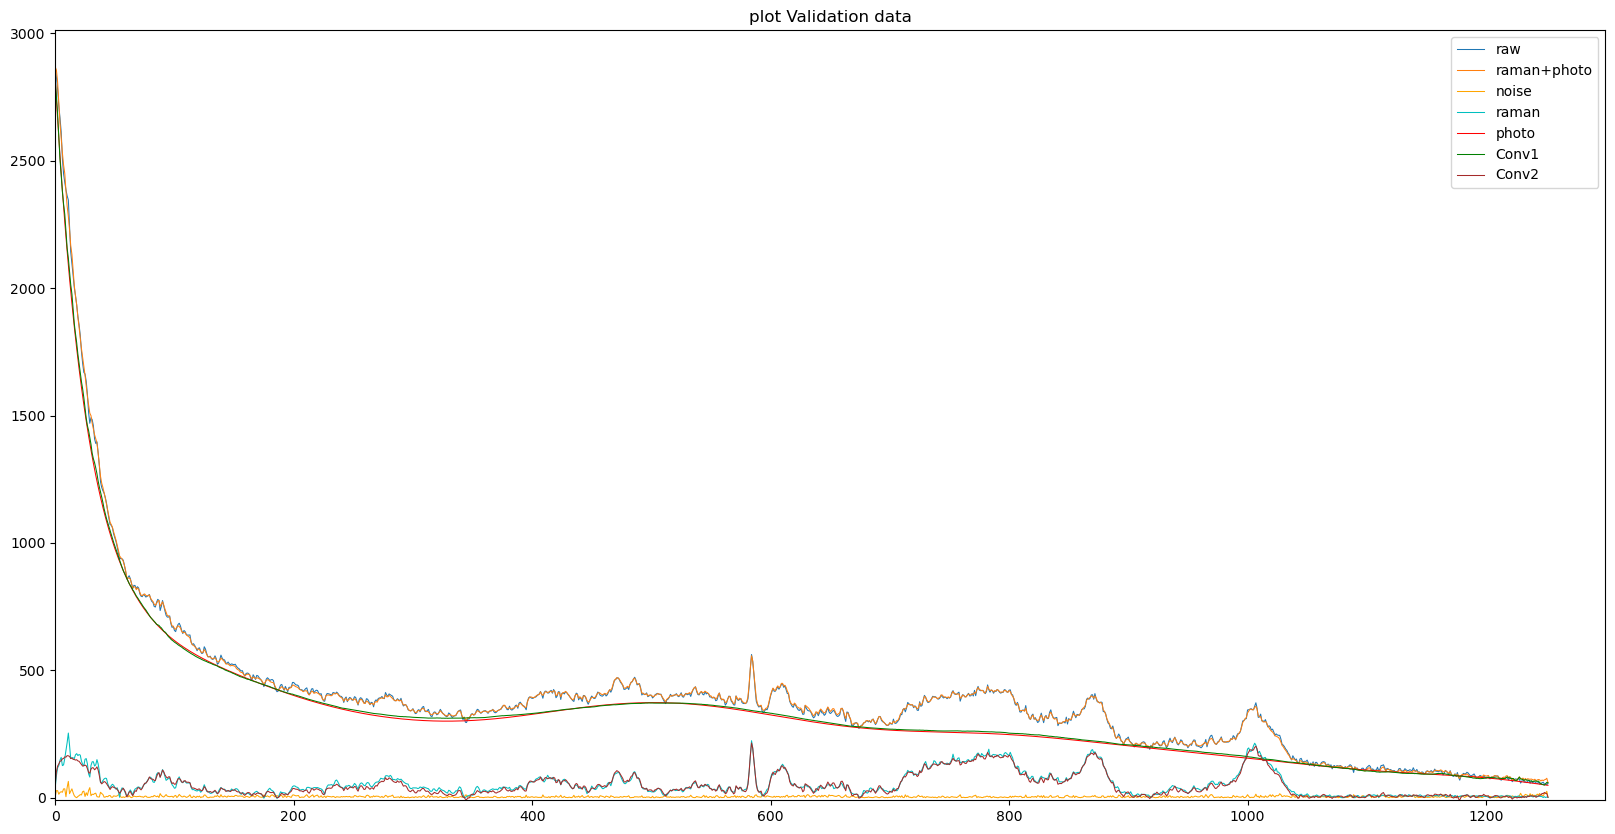

  2022-12-08 15:03:30|     0/  293| bits: 0.000277
Validation average loss: 0.0003274656774010509
--------------------------------------------------
Epoch  46/ 51


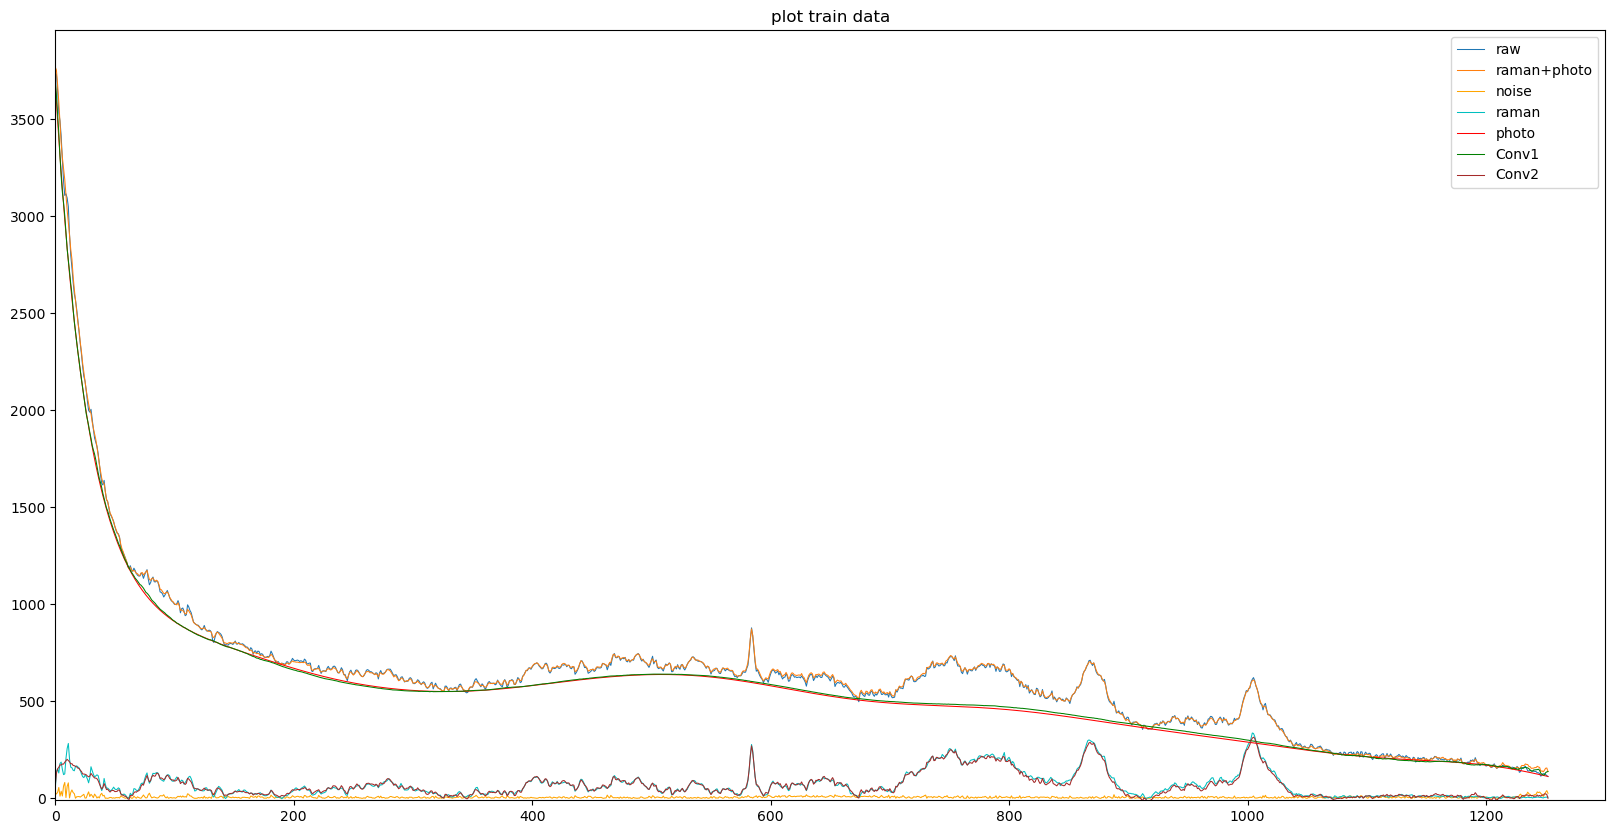

  2022-12-08 15:03:32|     0/ 2696| bits: 0.000282
Elapsed time: 0h 0m 35s


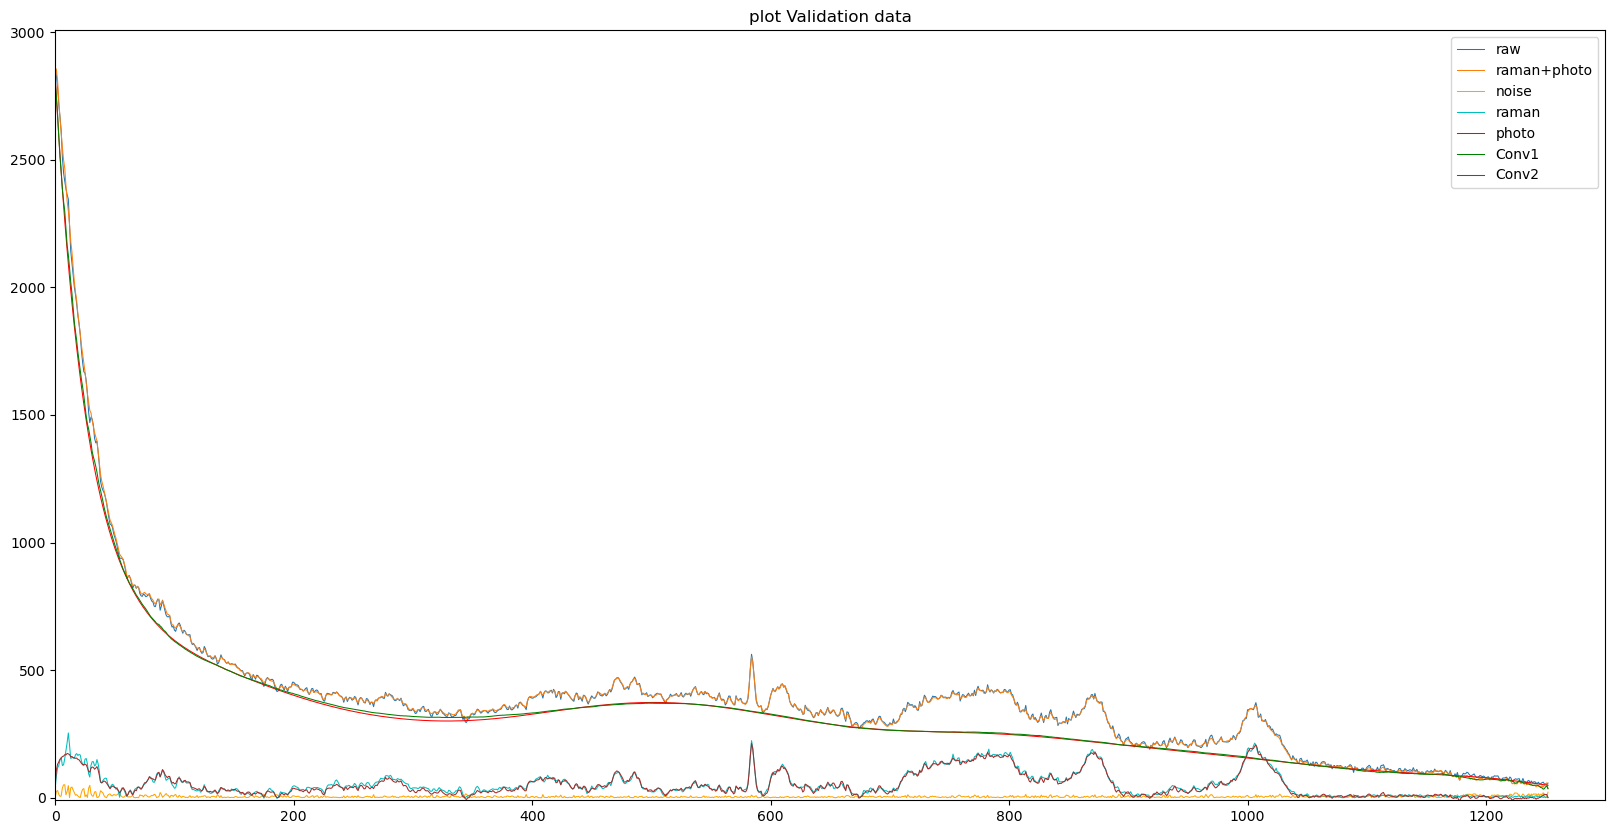

  2022-12-08 15:04:08|     0/  293| bits: 0.000288
Validation average loss: 0.00031280730036087334
--------------------------------------------------
Epoch  47/ 51


  2022-12-08 15:04:10|     0/ 2696| bits: 0.000358
Elapsed time: 0h 0m 35s


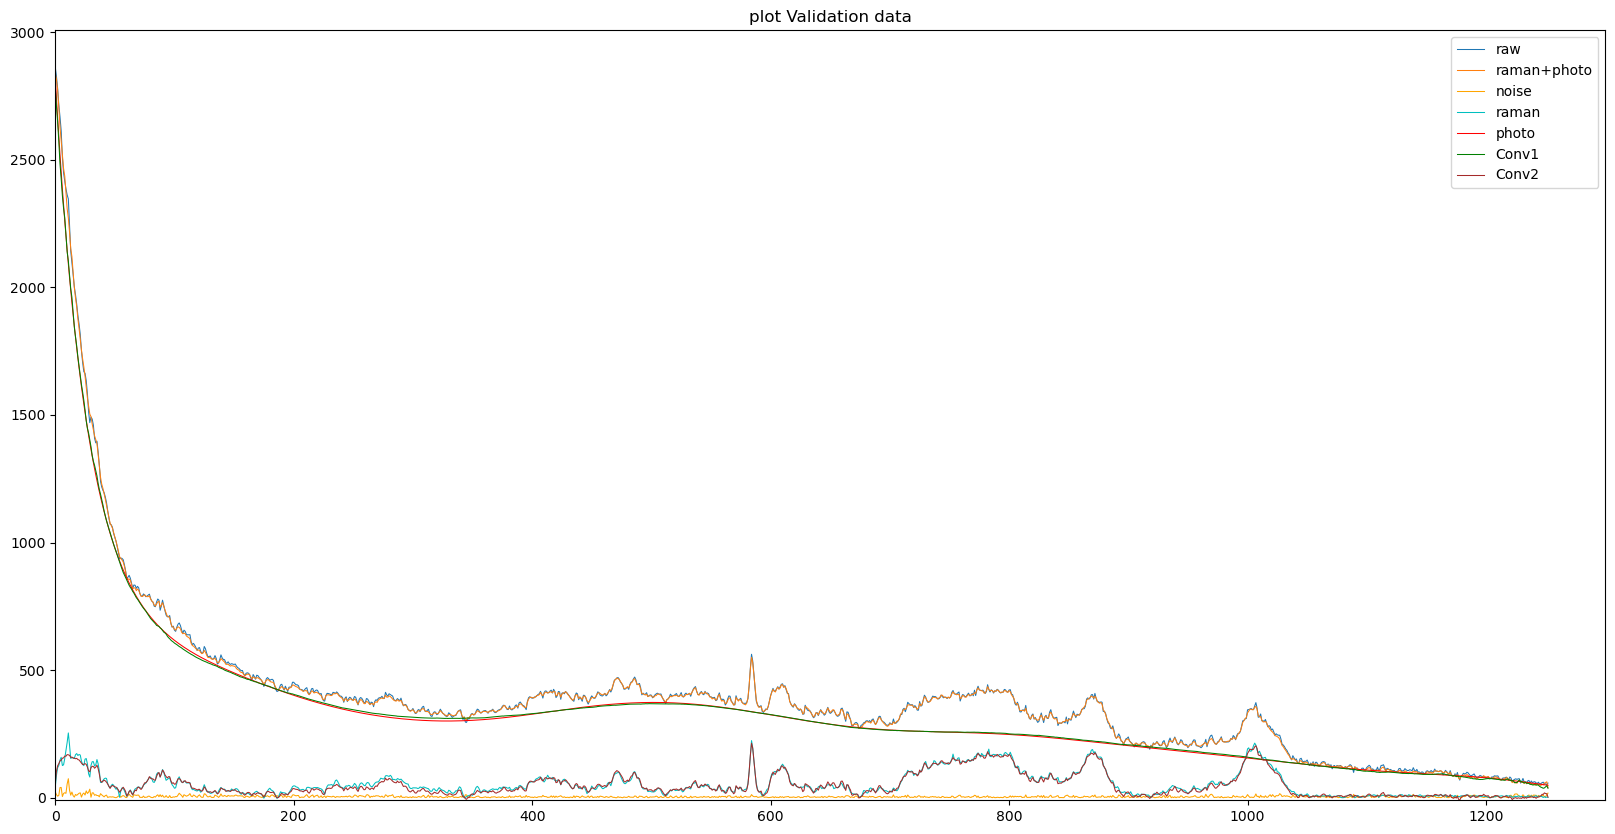

  2022-12-08 15:04:46|     0/  293| bits: 0.000277
Validation average loss: 0.00029290610109455884
--------------------------------------------------
Epoch  48/ 51


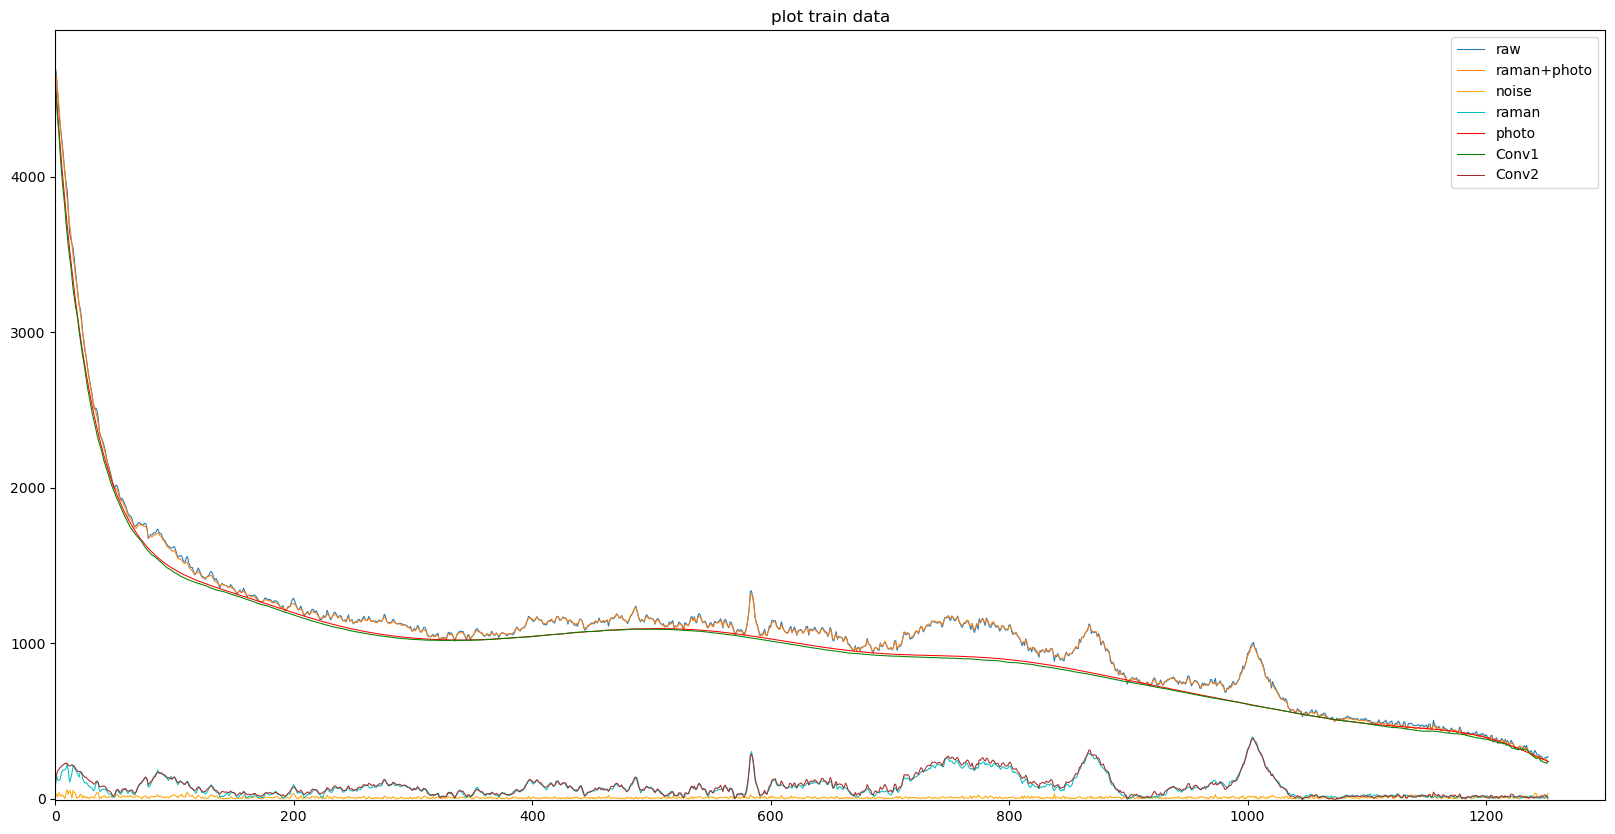

  2022-12-08 15:04:48|     0/ 2696| bits: 0.000287
Elapsed time: 0h 0m 35s


  2022-12-08 15:05:23|     0/  293| bits: 0.000280
Validation average loss: 0.00032185568124987185
--------------------------------------------------
Epoch  49/ 51


  2022-12-08 15:05:26|     0/ 2696| bits: 0.000295
Elapsed time: 0h 0m 35s


  2022-12-08 15:06:01|     0/  293| bits: 0.000288
Validation average loss: 0.0003272677422501147
--------------------------------------------------
Epoch  50/ 51


  2022-12-08 15:06:04|     0/ 2696| bits: 0.000326


In [ ]:
rvc = SupervisedClassifier(**kwargs)
rvc.fit(data)


In [ ]:
# for x, y1, y2, y_1, y_2 in rvc.predict():
#     indices = np.random.choice(BATCH_SIZE, 1, replace=False)
#     for i in indices:
#         plt.plot(x[i], label='raw')
#         plt.plot(y_1[i] + y_2[i], label='raman+photo')
#         plt.plot(y1[i], label='raman')
#         plt.plot(y2[i], label='photo')
#         plt.plot(y_1[i], label='Conv1')
#         plt.plot(y_2[i], label='Conv2')
#         plt.ylim(ymin=-10)
#         plt.xlim(xmin=0, xmax=1300)
#         plt.legend()
#         plt.show()